In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [2]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import sys

Populating the interactive namespace from numpy and matplotlib


In [3]:
max_seq_len = 50
batch_size = 1

### Import dataset

In [4]:
import json

DATADIR = 'data/'

word2ix_src_file = 'word2ix_en_filtered.json'
ix2word_src_file = 'ix2word_en_filtered.json'
word2ix_tgt_file = 'word2ix_fr_filtered.json'
ix2word_tgt_file = 'ix2word_fr_filtered.json'

pairs_file = 'pairs_en_fr_filtered.json'

with open(DATADIR + word2ix_src_file) as f:
    word2ix_src = json.load(f)
with open(DATADIR + ix2word_src_file) as f:
    ix2word_src = json.load(f)
with open(DATADIR + word2ix_tgt_file) as f:
    word2ix_tgt = json.load(f)
with open(DATADIR + ix2word_tgt_file) as f:
    ix2word_tgt = json.load(f)

with open(DATADIR + pairs_file) as f:
    pairs = json.load(f)
    
source_vocab_size = len(word2ix_src)
target_vocab_size = len(word2ix_tgt)

n_pairs = len(pairs)
np.random.shuffle(pairs)

#split into three subsets (train, dev, test)
train_pairs = pairs[:(9 * n_pairs// 10)] #90%
dev_pairs = pairs[(9 * n_pairs // 10):(19 * n_pairs // 20)] #5%
test_pairs = pairs[(19 * n_pairs // 20):]


In [27]:
def generate_pairs_batch(update_num, mode='train'):
    #0 is UNK, 1 is BOS, 2 is EOS, 3 is PAD
    #bos is only used in target_in
    # i is # of update
    
    if mode == 'train':
        dataset = train_pairs
    elif mode == 'dev':
        dataset = dev_pairs
    elif mode == 'test':
        dataset = test_pairs
        
    num_pairs = len(dataset)
    
    index = (update_num * batch_size) % len(dataset)
    
    pair = dataset[index]
    
    inputs = pair['source']
    targets_in = pair['target']
    targets_out = pair['target']

    # add <BOS> and <EOS> tokens
    inputs = inputs + [int(word2ix_src['<EOS>'])]
    targets_in = [int(word2ix_tgt['<BOS>'])] + targets_in
    targets_out = targets_out + [int(word2ix_tgt['<EOS>'])]    

    inputs = torch.LongTensor(inputs).unsqueeze(1)
    targets_in = torch.LongTensor(targets_in).unsqueeze(1)
    targets_out = torch.LongTensor(targets_out).unsqueeze(1)
    
    return inputs, targets_in, targets_out
    

### Creating models

In [6]:
class Seq2Seq(nn.Module):
    
    def __init__(self, source_vocab_size, target_vocab_size, embedding_size=256, hidden_size=256,
                 attention_size=256, num_layers=1, max_seq_len=30):
        super(Seq2Seq, self).__init__()
        
        self.max_seq_len = max_seq_len
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        
        self.encoder = Encoder(input_size=source_vocab_size, 
                               embedding_size=embedding_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers)
        
        self.decoder = Decoder(output_size=target_vocab_size,
                               embedding_size=embedding_size,
                               hidden_size=hidden_size,
                               attention_size=attention_size,
                               num_layers=num_layers)


In [7]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, embedding_size=256, hidden_size=256,
                 num_layers=1):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.hidden0 = nn.Parameter(torch.zeros(2*num_layers, 1, hidden_size))
        
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.encoder_rnn = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, 
                                  num_layers=num_layers, bidirectional=True)
        
    def forward(self, x):
        
        hidden = self._init_hidden()
        x = self.embedding(x)
        x, hidden = self.encoder_rnn(x, hidden)
        
        return x, hidden

    def _init_hidden(self):
        # initial hidden state is a learned bias parameter
        hidden = self.hidden0.clone().repeat(1, batch_size, 1)
        if use_cuda:
            hidden = hidden.cuda()

        return hidden


In [8]:
class Decoder(nn.Module):
    
    def __init__(self, output_size, embedding_size=256, hidden_size=256,
                 attention_size=256, num_layers=1):
        """
        We use the original attention mechanism from Bahdanau et al. 2014
        The layers are of this model correspond to the following notation in the original paper.
        
        attn_fc_prev_hid : Wa
        attn_fc_enc_hid : Ua
        attn_fc_context : va
        """
        super(Decoder, self).__init__()
        
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.attention_size = attention_size
        
        # attention
        self.attn_fc_prev_hid = nn.Linear(in_features=hidden_size, 
                                          out_features=attention_size)
        self.attn_fc_enc_hid = nn.Linear(in_features=2*hidden_size, 
                                         out_features=attention_size)
        self.attn_fc_context = nn.Linear(in_features=attention_size,
                                         out_features=1)
    
        self.embedding = nn.Embedding(num_embeddings=output_size, embedding_dim=embedding_size)    
        self.decoder_rnn = nn.GRU(input_size=(embedding_size + 2 * hidden_size), 
                                  hidden_size=hidden_size, 
                                  num_layers=num_layers)
        self.clf = nn.Linear(in_features=hidden_size, out_features=output_size)
        
        
    def forward(self, x, encoder_outputs):
        
        x = x.unsqueeze(0)

        # attention
        tmp1 = self.attn_fc_prev_hid(self.hidden)
        tmp2 = self.attn_fc_enc_hid(encoder_outputs)

        context_weights = self.attn_fc_context(F.tanh(tmp1 + tmp2))
        context_weights = F.softmax(context_weights, 0)
        self.attn_weights = context_weights #for attention plotting purposes
        
        context_weights = context_weights.permute(1, 2, 0) # (batch size x 1 x seq_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch size x seq_len x 2*hidden_dim)

        context_vector = torch.bmm(context_weights, encoder_outputs)
        context_vector = context_vector.permute(1, 0, 2) # (1 x batch_size x 2*hidden_dim)
        
        x = self.embedding(x)
        #concatenate previously predicted word embedding and context vector
        x = torch.cat((x, context_vector), dim=-1)
        x, self.hidden = self.decoder_rnn(x, self.hidden)
        x = self.clf(x)

        return x

    def _init_hidden(self, encoder_hidden_state):
        self.hidden = encoder_hidden_state[0].view(1, batch_size, -1)
        

### Training loop

In [46]:
def train(model, n_updates=10000, teacher_forcing_prob=0.5, print_every=100, 
          learning_rate=1e-3, save_model=False):

    if use_cuda:
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    loss_buffer = []
    loss_tracker = []

    # + 1 to show the last update
    for update in range(n_updates + 1):
        
        loss = 0
        teacher_forcing = True if np.random.random() < teacher_forcing_prob else False
        
        optimizer.zero_grad()

        inputs, targets_in, targets_out = generate_pairs_batch(update)

        inputs, targets_in, targets_out = Variable(inputs), Variable(targets_in), Variable(targets_out)
        if use_cuda:
            inputs, targets_in, targets_out = inputs.cuda(), targets_in.cuda(), targets_out.cuda()

        encoder_outputs, encoder_hidden = model.encoder(inputs)
        
        model.decoder._init_hidden(encoder_hidden)
                        
        if teacher_forcing:
            predicted_sequence = torch.zeros(len(targets_in)).long()
            if use_cuda:
                predicted_sequence = predicted_sequence.cuda()
            for i in range(len(targets_in)):
                output = model.decoder(targets_in[i], encoder_outputs)
                
                loss += criterion(output.view(batch_size, -1), targets_out[i])

                _, output = torch.max(output, -1)
                output = output.view(batch_size)
                predicted_sequence[i] = output.data[0]
        else:
            predicted_sequence = torch.ones(max_seq_len).long() * int(word2ix_tgt['<PAD>'])
            if use_cuda:
                predicted_sequence = predicted_sequence.cuda()
            # feeding BOS tokens for i=0
            output = Variable(torch.ones(batch_size).long())
            if use_cuda:
                output = output.cuda()
            #pad flag when predicted sequence is longer than target sequence
            pad = Variable(torch.ones(batch_size).long() * int(word2ix_tgt['<EOS>']))
            if use_cuda:
                pad = pad.cuda()
            for i in range(max_seq_len):
                output = model.decoder(output, encoder_outputs)
                if i < len(targets_out):
                    loss += criterion(output.view(batch_size, -1), targets_out[i])
                else:
                    loss += criterion(output.view(batch_size, -1), pad)

                _, output = torch.max(output, -1)
                output = output.view(batch_size)
                predicted_sequence[i] = output.data[0]
                if predicted_sequence[i] == int(word2ix_tgt['<EOS>']):
                    break
    
        loss.backward()
        optimizer.step()  
        
        loss_buffer.append(loss.data[0])

        if update % print_every == 0:
            
            if teacher_forcing:
                print("TEACHER FORCING")
            else:
                print("NO TEACHER FORCING")
            
            inputs = inputs[:,0]
            targets_out = targets_out[:,0]
            
#             print(inputs)
#             print(predicted_sequence)
#             print(targets_out)
            
            # convert all sequence to list (easier to read)
            inputs = [str(inputs.data[i]) for i in range(len(inputs))]
            predicted_sequence = [str(predicted_sequence[i]) for i in range(len(predicted_sequence))]
            targets_out = [str(targets_out.data[i]) for i in range(len(targets_out))]

            # create string of sentence
            og_sequence = ''.join(ix2word_src[elem] + ' ' for elem in inputs if ix2word_tgt[elem] != '<PAD>')
            pred_sequence = ''.join(ix2word_tgt[elem] + ' ' for elem in predicted_sequence if ix2word_tgt[elem] != '<PAD>')
            target_sequence = ''.join(ix2word_tgt[elem] + ' ' for elem in targets_out if ix2word_tgt[elem] != '<PAD>')
            
            #mean over print_every batches of loss
            loss_tracker.append(np.mean(loss_buffer))
            loss_buffer = []
            
            print("Update : %d ----- Loss : %.3f\n-----------------------------" % (update, loss_tracker[-1]))
            print("Original sequence  : %s" % og_sequence)
            print("Predicted sequence : %s" % pred_sequence)
            print("Target sequence    : %s\n" % target_sequence)
            
            if save_model:
                #saving encoder and decoder separately
                torch.save(model.encoder.state_dict(), 'seq2seq_encoder_en_fr.pt')
                torch.save(model.decoder.state_dict(), 'seq2seq_decoder_en_fr.pt')
                
                #saving loss progress
                np.savetxt('seq2seq_en_fr_loss.txt', np.array(loss_tracker))
    
    return loss_tracker


In [10]:
model = Seq2Seq(source_vocab_size=source_vocab_size, target_vocab_size=target_vocab_size)

In [ ]:
model.encoder.load_state_dict(torch.load('seq2seq_encoder_en_fr.pt'))
model.decoder.load_state_dict(torch.load('seq2seq_decoder_en_fr.pt'))

In [47]:
loss_tracker = train(model, n_updates = 1000000, print_every=1000, save_model=True)

NO TEACHER FORCING
Update : 0 ----- Loss : 263.223
-----------------------------
Original sequence  : here too there is just one small unresolved issue . <EOS> 
Predicted sequence : il est une une est une bonne si les etats 
Target sequence    : ici aussi il subsiste un seul point mineur non resolu . <EOS> 

TEACHER FORCING
Update : 1000 ----- Loss : 112.834
-----------------------------
Original sequence  : with the genetically modified soya seeds used this year in the usa for food production we have seen the first genetically modified plant raw goods arrive in europe . <EOS> 
Predicted sequence : l est agit la proposition de traite avons de de le europe du a ont ete l annee de consequences membres pour la consequences prealables . que pour . les pour les commission lecture que matiere . <EOS> 
Target sequence    : c est avec la culture de soja genetiquement modifie pour l industrie alimentaire qui a debute cette annee aux etats unis que des matieres premieres vegetales modifiees gene

KeyboardInterrupt: 

In [76]:
import matplotlib.ticker as ticker

def show_attention(model, teacher_forcing=True):
    
    inputs, targets_in, targets_out = generate_pairs_batch()
    inputs, targets_in, targets_out = Variable(inputs), Variable(targets_in), Variable(targets_out)
    if use_cuda:
        inputs, targets_in, targets_out = inputs.cuda(), targets_in.cuda(), targets_out.cuda()

    encoder_outputs, encoder_hidden = model.encoder(inputs)

    model.decoder._init_hidden(encoder_hidden)

    predicted_sequence = torch.zeros(len(targets_in)).long()
    if use_cuda:
        predicted_sequence = predicted_sequence.cuda()
        
    attention_weights = torch.zeros(len(inputs), len(targets_out))

    for i in range(len(targets_in)):
        if teacher_forcing:
            output = model.decoder(targets_in[i], encoder_outputs)
        else:
            if i == 0:
                # feeding BOS tokens
                output = torch.ones((1, batch_size)).long()                
            output = model.decoder(output, encoder_outputs) 
                    
        attention_weights[:,i] = model.decoder.attn_weights.data[:,0].squeeze()

        _, predicted_word = torch.max(output, -1)
        predicted_word = predicted_word.view(batch_size)
        predicted_sequence[i] = predicted_word.data[0]
    
    #preparing the inputs by removing the padding
    attn_in = inputs.data[:,0].cpu().numpy()
    # attn_out = targets_out.data[:,0].cpu().numpy()
    attn_out = predicted_sequence
    
    while attn_in[-1] != 2:
        attn_in = attn_in[:-1]
    while attn_out[-1] != 2:
        attn_out = attn_out[:-1]
    
    attention_weights = attention_weights[:len(attn_in), :len(attn_out)]

    attn_in_str = [ix2word_src[str(attn_in[i])] for i in range(len(attn_in))]
    attn_out_str = [ix2word_tgt[str(attn_out[i])] for i in range(len(attn_out))]
    
    # plot figure
    fig, ax = plt.subplots(figsize=(8, 8))    
    ax.matshow(attention_weights.numpy(), cmap='bone')

    # Set up axes
    ax.set_xticklabels([''] + attn_out_str, rotation=90)
    ax.set_yticklabels([''] + attn_in_str)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.savefig("attention.png")

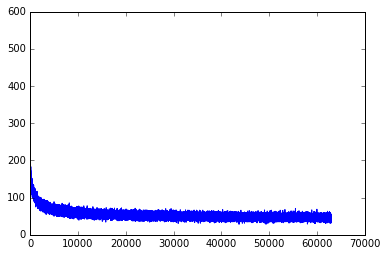

In [62]:
def show_learning_curve(loss_tracker):
    
    plt.plot(loss_tracker)
    plt.show()
    
loss_tracker_file = 'seq2seq_en_fr_loss.txt'
loss_tracker = np.loadtxt(loss_tracker_file)
show_learning_curve(loss_tracker)

In [19]:
model = Seq2Seq(source_vocab_size=source_vocab_size, target_vocab_size=target_vocab_size)
if use_cuda:
    model = model.cuda()

# pretrained model
pretrained_encoder_file = 'seq2seq_encoder_en_fr.pt'
pretrained_decoder_file = 'seq2seq_decoder_en_fr.pt'
model.encoder.load_state_dict(torch.load(pretrained_encoder_file))
model.decoder.load_state_dict(torch.load(pretrained_decoder_file))

16
21


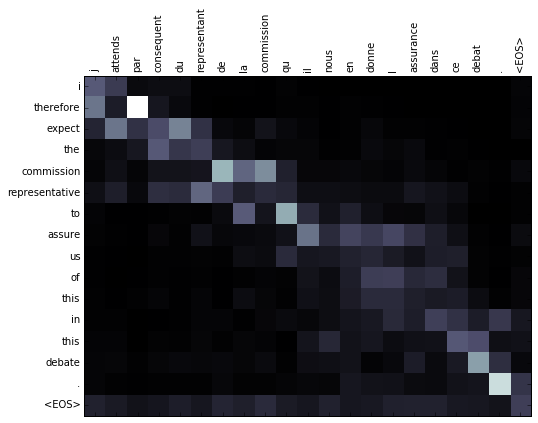

In [77]:
show_attention(model)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu_score(model, n_updates=100, mode='dev'):
    
    score = 0
    #we do a mean over 100 updates for the BLEU score on the dev and test set
    for update in range(n_updates):
        inputs, _, targets_out = generate_pairs_batch(update, mode=mode)
    
        
        
        score = +=sentence_bleu()

In [28]:
torch.cuda.empty_cache()

In [29]:
del model

In [30]:
!nvidia-smi

Fri Apr 20 19:37:07 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0  On |                  N/A |
| 25%   35C    P2    25W / 120W |   5945MiB /  6069MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [26]:
!top

=top - 19:36:16 up  6:48,  1 user,  load average: 0.94, 0.59, 0.42
Tasks: 340 total,   2 running, 338 sleeping,   0 stopped,   0 zombie
%Cpu(s):  6.7 us,  0.9 sy,  0.1 ni, 92.0 id,  0.1 wa,  0.0 hi,  0.1 si,  0.0 st
KiB Mem : 16383700 total,  1088484 free, 14751352 used,   543864 buff/cache
KiB Swap: 16729084 total, 15165668 free,  1563416 used.  1133212 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
10569 patrice   20   0 1224372 140952  47316 R  18.8  0.9   1:11.23 chrome      
 2458 root      20   0  399720   7832   1428 S   6.2  0.0   0:34.56 docker-con+ 
10458 patrice   20   0 1301448 180392  65436 S   6.2  1.1   0:29.84 chrome      
10523 patrice   20   0  613752 141220  50260 S   6.2  0.9   0:18.49 chrome      
10686 patrice   20   0 1258864 115500  16840 S   6.2  0.7   0:35.15 chrome      
11447 patrice   20   0   41928   3616   2976 R   6.2  0.0   0:00.01 top         
    1 root      20   0  185500    596    180 S   0.0  0.0   0:0